In [1]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

# Package for storing reformed image
import imageio

In [2]:
def generate_Y(W, img):
    n, m = img.shape
    y = W @ img.reshape(n * m, 1)
    return y

In [3]:
def generate_V1_variables(numCell, cellSize, sparseFreq, img):
    # Get size of image
    dim = np.asanyarray(img).shape
    n, m = dim
    # Store generated V1 cells in W
    W = V1_weights(numCell, dim, cellSize, sparseFreq) 
    
    # Retrieve y from W @ imgArr
    y = W @ img.reshape(n*m, 1)

    # Resize W to shape (numCell, height of image, width of image) for fetching into function
    W = W.reshape(numCell, dim[0], dim[1])
    return W, y

In [4]:

# Function: compress
# Parameters:
##     W: An opened index for measurement
##     y: the value of the opened index W
##     alpha: panelty value to fit for Lasso
##     dim (n, m): image size that needs to be reformed

# Return:
##     theta: matrix of W when FFT took in place
##     reformed: Reformed image in array
##     s: sparse vector s which is a estimated coefficient generated from LASSO
def compress(W, y, alpha):
    sampleSz, n, m = W.shape
    
    ## WΨ
    theta = fft.dctn(W.reshape(sampleSz, n, m), norm = 'ortho', axes = [1, 2])
    theta = theta.reshape(sampleSz, n * m)

    ## Initialize Lasso and Fit data
    mini = Lasso(alpha = alpha)
    mini.fit(theta, y)
    
    ## Retrieve sparse vector s
    s = mini.coef_
    
    # Reform the image using sparse vector s with inverse descrete cosine
    reform = fft.idctn(s.reshape(n, m), norm='ortho', axes=[0,1])
    
    #return theta, reformed img, sparse vectors
    return theta, reform, s

Lossy conversion from float64 to uint8. Range [34.395455485093834, 236.66972622782595]. Convert image to uint8 prior to saving to suppress this warning.


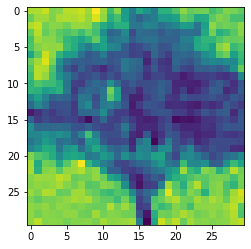

In [6]:
## Changing V1 weight for each time

# took 30 X 30 pixel part of tree image at about coord(650, 260)
input_img = "image/tree_part1.jpg"
img = Image.open(input_img)
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

num_cell = 500   

cell_size = 1 
sparse_freq = 1 

W, y = generate_V1_variables(num_cell, cell_size, sparse_freq, img_arr)

## Return reform image array
theta, reform, s = compress(W, y, 1)


imageio.imwrite('reformedImage.jpeg', reform)

plt.imshow(reform)

In [7]:
## Making V1 weight to be consistent

img = Image.open("image/tree_part1.jpg")
img = ImageOps.grayscale(img)
img_arr = np.asarray(img)

# V1 Variables
num_cell = 100
cell_size = 2
sparse_freq = 2
dim = img_arr.shape
n,m = dim

W = V1_weights(num_cell, dim, cell_size, sparse_freq) 
y = generate_Y(W, img_arr)
W_rev = W.reshape(num_cell, n, m)
theta, reform, s = compress(W_rev, y, 50)
